In [1]:
import torchaudio, torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Sample wav files

In [2]:
wav = 'data1/train/train_00001_m_01_0.wav' #  https://github.com/soerenab/AudioMNIST
# wav = 'audio1.wav' # https://en.wikipedia.org/wiki/Singing
# wav = 'audio2.wav' # https://www.chineasy.com/mandarin-chinese-pronunciation-an-introduction/

# Waveform

In [3]:
x, fs = torchaudio.load(wav)
print(x.shape)

torch.Size([1, 10403])


# Mel-spectrogram

torch.Size([1, 80, 66])


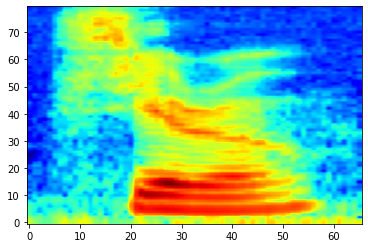

In [4]:
melspecgram = torchaudio.transforms.MelSpectrogram(
    n_fft=512, win_length=25*16, hop_length=10*16, n_mels=80)(x)    # 25ms window, 10ms shift
print(melspecgram.shape)
log_melspecgram = melspecgram.log()
plt.imshow(log_melspecgram[0].numpy(), cmap='jet', aspect='auto',origin='lower')

# SpecAugment

Specaugment is a data augmentation method for speech recognition. It randomly masks the mel-spectrogram in the time and frequency domain.

Park, Daniel S., et al. "Specaugment: A simple data augmentation method for automatic speech recognition." arXiv preprint arXiv:1904.08779 (2019).

https://github.com/pyyush/SpecAugment

warp 62
f 15 21
t 48 50
torch.Size([1, 80, 62])


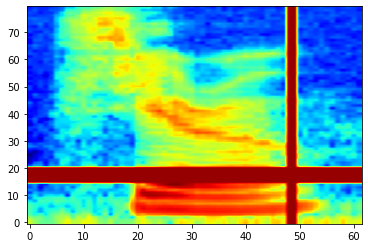

In [5]:
# https://github.com/TaoRuijie/ECAPA-TDNN/blob/main/model.py#L96
# https://github.com/DemisEom/SpecAugment/blob/master/SpecAugment/spec_augment_pytorch.py
class SpecAug(torch.nn.Module):
    def __init__(self, prob_t_warp=0.5,
                       t_factor=(0.9, 1.1), 
                       f_mask_width = (0, 8), 
                       t_mask_width = (0, 10),
                       nb_f_masks=[1,2], 
                       nb_t_masks=[1,2], 
                       ):
        super().__init__()
        self.t_factor = t_factor
        self.f_mask_width = f_mask_width
        self.t_mask_width = t_mask_width
        self.nb_f_masks = nb_f_masks
        self.nb_t_masks = nb_t_masks
        self.prob_t_warp = prob_t_warp

    def time_warp(self, x):
        x = torch.nn.functional.interpolate(x, size=(int(x.shape[2]*np.random.uniform(*self.t_factor)), ))
        print('warp', x.shape[2])
        return x
    
    def freq_mask(self, x):
        for _ in range(np.random.randint(*self.nb_f_masks)):
            f = np.random.randint(*self.f_mask_width)
            f0 = np.random.randint(0, x.shape[1]-f)
            print('f', f0, f0+f)
            x[:,f0:f0+f,:] = 0
        return x

    def time_mask(self, x):
        for _ in range(np.random.randint(*self.nb_t_masks)):
            t = np.random.randint(*self.t_mask_width)
            t0 = np.random.randint(0, x.shape[2]-t)
            print('t', t0, t0+t)
            x[:,:,t0:t0+t] = 0
        return x

    def forward(self, x):
        if np.random.uniform() < self.prob_t_warp:
            x = self.time_warp(x)
        x = self.freq_mask(x)
        x = self.time_mask(x)
        return x
    
specaug = SpecAug()
aug_log_melspecgram = specaug(log_melspecgram)
print(aug_log_melspecgram.shape)
plt.imshow(aug_log_melspecgram[0].numpy(), cmap='jet', aspect='auto',origin='lower')